In [1]:
%cd /home/tae898/repos/erc/

/home/tae898/repos/erc


In [2]:
ROOT_DIR = './multimodal-datasets/'
model_checkpoint = 'results/MELD/roberta-large/2021-05-23-00-20-58/4/checkpoint-12490/'
# model_checkpoint = 'results/IEMOCAP/roberta-large/2021-05-21-07-58-04/3/checkpoint-4780/'
DATASET = model_checkpoint.split('/')[1]


import yaml

def read_json(path):
    with open(path, 'r') as stream:
        foo = json.load(stream)
    return foo

def read_yaml(path):
    with open(path, 'r') as stream:
        foo = yaml.load(stream)
    return foo


kwargs_path = f"{'/'.join(model_checkpoint.split('/')[:-3])}/kwargs.yaml"    
kwargs = read_yaml(kwargs_path)
kwargs

/home/tae898/.virtualenvs/dev-python3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  app.launch_new_instance()


{'ADD_BOU_EOU': False,
 'ADD_SPEAKER_TOKENS': True,
 'BATCH_SIZE': 4,
 'DATASET': 'MELD',
 'HP_N_TRIALS': 5,
 'HP_ONLY_UPTO': 103,
 'NUM_TRAIN_EPOCHS': 5,
 'REPLACE_NAMES_IN_UTTERANCES': False,
 'SEEDS': [0, 1, 2, 3, 4],
 'SPEAKER_SPLITS': ['train', 'val', 'test'],
 'WARMUP_RATIO': 0.2,
 'WEIGHT_DECAY': 0.01,
 'model_checkpoint': 'roberta-large',
 'num_future_utterances': 0,
 'num_past_utterances': 1000,
 'training_config': 'train-erc-text2.yaml'}

In [4]:
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification
from utils import get_num_classes, ErcTextDataset
import numpy as np
import matplotlib.pyplot as plt

NUM_CLASSES = get_num_classes(DATASET)
tokenizer = RobertaTokenizerFast.from_pretrained(
    model_checkpoint)

model = RobertaForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=NUM_CLASSES)

model.eval()
model.cpu()

SEED = int(model_checkpoint.split('/')[-3])
print(SEED)

ds_train = ErcTextDataset(DATASET=DATASET, SPLIT='train',
                          num_past_utterances=kwargs['num_past_utterances'], num_future_utterances=kwargs['num_future_utterances'],
                          model_checkpoint=f"{'/'.join(model_checkpoint.split('/')[:-3])}/tokenizer",
                          ADD_BOU_EOU=kwargs['ADD_BOU_EOU'], ADD_SPEAKER_TOKENS=kwargs['ADD_SPEAKER_TOKENS'],
                          REPLACE_NAMES_IN_UTTERANCES=kwargs['REPLACE_NAMES_IN_UTTERANCES'],
                          ROOT_DIR=ROOT_DIR, SEED=SEED)

ds_val = ErcTextDataset(DATASET=DATASET, SPLIT='val',
                          num_past_utterances=kwargs['num_past_utterances'], num_future_utterances=kwargs['num_future_utterances'],
                          model_checkpoint=f"{'/'.join(model_checkpoint.split('/')[:-3])}/tokenizer",
                          ADD_BOU_EOU=kwargs['ADD_BOU_EOU'], ADD_SPEAKER_TOKENS=kwargs['ADD_SPEAKER_TOKENS'],
                          REPLACE_NAMES_IN_UTTERANCES=kwargs['REPLACE_NAMES_IN_UTTERANCES'],
                          ROOT_DIR=ROOT_DIR, SEED=SEED)

ds_test = ErcTextDataset(DATASET=DATASET, SPLIT='test',
                          num_past_utterances=kwargs['num_past_utterances'], num_future_utterances=kwargs['num_future_utterances'],
                          model_checkpoint=f"{'/'.join(model_checkpoint.split('/')[:-3])}/tokenizer",
                          ADD_BOU_EOU=kwargs['ADD_BOU_EOU'], ADD_SPEAKER_TOKENS=kwargs['ADD_SPEAKER_TOKENS'],
                          REPLACE_NAMES_IN_UTTERANCES=kwargs['REPLACE_NAMES_IN_UTTERANCES'],
                          ROOT_DIR=ROOT_DIR, SEED=SEED)

4


2021-05-23 15:23:31.655 INFO utils - _load_utterance_ordered: every text file exists fine!
2021-05-23 15:23:31.656 INFO utils - _string2tokens: converting utterances into tokens ...
2021-05-23 15:23:31.660 INFO utils - _string2tokens: creating input utterance data ... 
100%|██████████| 1038/1038 [00:23<00:00, 44.09it/s]
2021-05-23 15:23:56.149 INFO utils - _create_input: number of truncated utterances: 2
2021-05-23 15:23:56.200 INFO utils - _load_utterance_ordered: every text file exists fine!
2021-05-23 15:23:56.201 INFO utils - _string2tokens: converting utterances into tokens ...
2021-05-23 15:23:56.203 INFO utils - _string2tokens: creating input utterance data ... 
100%|██████████| 114/114 [00:01<00:00, 95.71it/s]
2021-05-23 15:23:58.357 INFO utils - _create_input: number of truncated utterances: 0
2021-05-23 15:23:58.452 INFO utils - _load_utterance_ordered: every text file exists fine!
2021-05-23 15:23:58.453 INFO utils - _string2tokens: converting utterances into tokens ...
2021

In [5]:
def get_random_sample(ds_test, tokenizer, idx=None, max_tokens=512):
    while True:
        if idx is None:
            idx_ = np.random.randint(0, len(ds_test))
        else:
            idx_ = idx
        random_sample = ds_test[idx_]
        input_ids, attention_mask, labelid = random_sample['input_ids'], random_sample['attention_mask'], random_sample['label']
        break
#         if len(input_ids) < max_tokens and labelid != 0:
#             break

    decoded = tokenizer.decode(input_ids)

    input_ids = torch.tensor(input_ids).view(-1, len(input_ids))
    attention_mask = torch.tensor(attention_mask).view(-1, len(attention_mask))
    labelid = torch.tensor(labelid).view(-1, 1)
    

    return idx_, input_ids, attention_mask, labelid, decoded

def return_coeffs(tokenizer, input_ids, attentions, BATCH_IDX=0, LAYER=-1, QUERY_TOKEN_IDX=0, annoying_char='Ġ'):
    tokens = tokenizer.convert_ids_to_tokens(input_ids[BATCH_IDX].tolist())
    QUERY_TOKEN = tokens[QUERY_TOKEN_IDX].split(annoying_char)[-1]

    coeffs = attentions[LAYER][BATCH_IDX].cpu().detach().numpy().sum(axis=0)[QUERY_TOKEN_IDX]
    coeffs /= coeffs.sum()
    
    idx_token_coeffs = [(idx, token.split(annoying_char)[-1], coeffs[idx]) for idx, token in enumerate(tokens)]
    
    assert len(coeffs) == len(tokens) == len(idx_token_coeffs)
    
    
    return QUERY_TOKEN, coeffs, tokens, idx_token_coeffs


In [16]:
import pprint
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

ds = ds_train

idx, input_ids, attention_mask, labelid, decoded = get_random_sample(ds, tokenizer, max_tokens=512)
pprint.pprint(f"{decoded}")
print()

outputs = model(**{'input_ids': input_ids, 'attention_mask': attention_mask}, labels=labelid, output_attentions=True, output_hidden_states=True)
attentions = outputs.attentions
pred = int(outputs.logits.argmax().numpy())
truth = int(labelid[0][0].numpy())

pprint.pprint(f"data_idx: {idx}")
pprint.pprint(f"pred: {ds.id2emotion[pred]}")
pprint.pprint(f"truth: {ds.id2emotion[truth]}")
pprint.pprint(f"number of tokens in the input: {input_ids.shape[1]}")
print()

('<s><Monica>What, Phoebe, did you whip the potatoes? Ross needs '
 "lumps!<Phoebe>Oh, I'm sorry, oh, I just, I thought we could have them "
 'whipped and then add some peas and onions.<Monica>Why would we do '
 "that?<Phoebe>Well, 'cause then they'd be like my mom used to make them, you "
 'know, before she died.<Monica>Ok, three kinds of potatoes coming '
 'up.<Rachel>Ok, good-bye you guys. Thanks for everything.  Oh, sorry! Oh, '
 'sorry!<Chandler>The most unbelievable thing has happened. Underdog has just '
 'gotten away.<Joey>The balloon?<Chandler>No, no, the actual cartoon '
 "character. Of course the balloon. It's all over the news. Right before he "
 "reached<Rachel>I can't, I gotta go.</s></s><Chandler>Come on. An 80-foot "
 'inflatable dog let loose over the city. How often does that happen?</s>')

'data_idx: 6962'
'pred: surprise'
'truth: surprise'
'number of tokens in the input: 189'



In [17]:
decoded

"<s><Monica>What, Phoebe, did you whip the potatoes? Ross needs lumps!<Phoebe>Oh, I'm sorry, oh, I just, I thought we could have them whipped and then add some peas and onions.<Monica>Why would we do that?<Phoebe>Well, 'cause then they'd be like my mom used to make them, you know, before she died.<Monica>Ok, three kinds of potatoes coming up.<Rachel>Ok, good-bye you guys. Thanks for everything.  Oh, sorry! Oh, sorry!<Chandler>The most unbelievable thing has happened. Underdog has just gotten away.<Joey>The balloon?<Chandler>No, no, the actual cartoon character. Of course the balloon. It's all over the news. Right before he reached<Rachel>I can't, I gotta go.</s></s><Chandler>Come on. An 80-foot inflatable dog let loose over the city. How often does that happen?</s>"

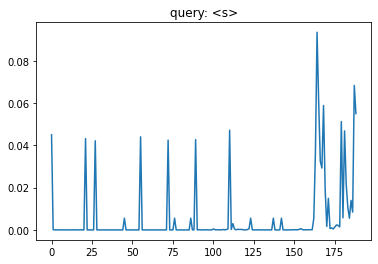

[(0, '<s>', 0.044984117), (1, '<Monica>', 9.72464e-05), (2, 'What', 2.3259987e-05), (3, ',', 2.1015618e-05), (4, 'Ph', 4.7319845e-06), (5, 'oe', 2.6137507e-06), (6, 'be', 2.2559886e-06), (7, ',', 6.6680664e-06), (8, 'did', 5.783015e-06), (9, 'you', 6.279099e-06), (10, 'whip', 3.3648075e-06), (11, 'the', 1.811986e-06), (12, 'potatoes', 6.313675e-06), (13, '?', 6.0539587e-05), (14, 'Ross', 1.9133206e-05), (15, 'needs', 1.4181934e-05), (16, 'l', 4.3606988e-06), (17, 'umps', 1.7595567e-06), (18, '!', 8.800384e-05), (19, '<Phoebe>', 4.5664567e-08), (20, 'Oh', 1.5964352e-07), (21, ',', 0.043216366), (22, 'I', 7.2749167e-06), (23, "'m", 1.9376641e-07), (24, 'sorry', 1.5710873e-07), (25, ',', 3.280363e-06), (26, 'oh', 2.457363e-07), (27, ',', 0.04217251), (28, 'I', 2.3541906e-08), (29, 'just', 3.20099e-08), (30, ',', 7.4687847e-07), (31, 'I', 6.8004745e-08), (32, 'thought', 7.831803e-08), (33, 'we', 9.379335e-08), (34, 'could', 1.1770959e-07), (35, 'have', 2.2246789e-07), (36, 'them', 3.050426

In [18]:
QUERY_TOKEN, coeffs, tokens, idx_token_coeffs = return_coeffs(tokenizer, input_ids, attentions, LAYER=-1, QUERY_TOKEN_IDX=0)

plt.figure()
plt.plot(coeffs);
plt.title(f'query: {QUERY_TOKEN}')
plt.show()

print(idx_token_coeffs)
print()

top_10 = sorted(idx_token_coeffs, key=lambda x:-x[2])[:10]
print(top_10)

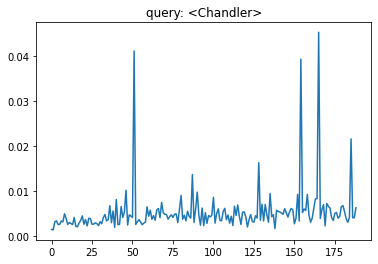

[(0, '<s>', 0.0014912181), (1, '<Monica>', 0.0013798213), (2, 'What', 0.0031515975), (3, ',', 0.003406204), (4, 'Ph', 0.0026011767), (5, 'oe', 0.0026050417), (6, 'be', 0.0033469226), (7, ',', 0.0031571798), (8, 'did', 0.0049630026), (9, 'you', 0.003922203), (10, 'whip', 0.0025886442), (11, 'the', 0.0030237166), (12, 'potatoes', 0.0028034095), (13, '?', 0.0025607198), (14, 'Ross', 0.004151361), (15, 'needs', 0.0021733604), (16, 'l', 0.0020769273), (17, 'umps', 0.0029078582), (18, '!', 0.0034989407), (19, '<Phoebe>', 0.0045047663), (20, 'Oh', 0.0026237713), (21, ',', 0.0036859426), (22, 'I', 0.002267232), (23, "'m", 0.0039752517), (24, 'sorry', 0.003901202), (25, ',', 0.002639627), (26, 'oh', 0.0026689717), (27, ',', 0.0029547855), (28, 'I', 0.0027811467), (29, 'just', 0.0023303393), (30, ',', 0.0032245747), (31, 'I', 0.0027580536), (32, 'thought', 0.0041479967), (33, 'we', 0.0048074317), (34, 'could', 0.0033659802), (35, 'have', 0.0036700033), (36, 'them', 0.0067697726), (37, 'whipped',

In [19]:
QUERY_TOKEN, coeffs, tokens, idx_token_coeffs = return_coeffs(tokenizer, input_ids, attentions, LAYER=0, QUERY_TOKEN_IDX=165)

plt.figure()
plt.plot(coeffs);
plt.title(f'query: {QUERY_TOKEN}')
plt.show()

print(idx_token_coeffs)
print()

top_10 = sorted(idx_token_coeffs, key=lambda x:-x[2])[:10]
print(top_10)